In [ ]:
+!curl -L -o dataset.zip https://www.kaggle.com/api/v1/datasets/download/josshhh/mri-scans-brain-tumor-image-dataset
! unzip dataset.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  148M  100  148M    0     0  26.0M      0  0:00:05  0:00:05 --:--:-- 33.8M
Archive:  dataset.zip
replace brain_tumor/brain_tumor/Testing/glioma/Te-gl_0037.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: NO


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import pandas as pd

In [ ]:
train_dir = "/content/brain_tumor/brain_tumor/Training"
test_dir = "/content/brain_tumor/brain_tumor/Testing"
val_dir = "/content/brain_tumor/brain_tumor/Validation"

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


test_datagen = ImageDataGenerator(rescale=1.0/255.0)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 5712 images belonging to 4 classes.
Found 1111 images belonging to 4 classes.
Found 200 images belonging to 4 classes.


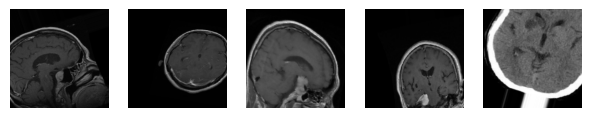

In [ ]:

import matplotlib.pyplot as plt


images, labels = next(train_generator)

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 10, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()


In [ ]:

from tensorflow.keras.applications import ResNet50


base_model = ResNet50(weights='imagenet',
                     include_top=False,
                     input_shape=(224, 224, 3))


for layer in base_model.layers[-10:]:
    layer.trainable = False


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
from tensorflow.keras.optimizers import SGD
optimizer = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [ ]:

history = model.fit(train_generator,epochs=10, validation_data=val_generator,callbacks=[early_stopping])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 174s 647ms/step - accuracy: 0.3919 - loss: 1.8629 - val_accuracy: 0.2600 - val_loss: 1.4829
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 90s 493ms/step - accuracy: 0.7195 - loss: 0.7074 - val_accuracy: 0.2850 - val_loss: 1.4216
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 90s 502ms/step - accuracy: 0.8300 - loss: 0.4642 - val_accuracy: 0.3150 - val_loss: 1.5681
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 89s 498ms/step - accuracy: 0.8846 - loss: 0.3376 - val_accuracy: 0.3700 - val_loss: 2.7609
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 91s 507ms/step - accuracy: 0.9133 - loss: 0.2710 - val_accuracy: 0.6850 - val_loss: 0.8241
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 89s 495ms/step - accuracy: 0.9224 - loss: 0.2451 - val_accuracy: 0.8350 - val_loss: 0.6657
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 89s 496ms/step - accuracy: 0.9462 - loss: 0.1730 - val_accuracy: 0.9350 - val_loss: 0.1834
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 91s 505ms/step - accuracy: 0.9527 - loss: 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes


print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 199ms/step - accuracy: 0.9602 - loss: 0.1151
Test Accuracy: 0.963996410369873
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 207ms/step
              precision    recall  f1-score   support

      glioma       0.25      0.22      0.24       250
  meningioma       0.23      0.25      0.24       256
     notumor       0.32      0.32      0.32       355
   pituitary       0.27      0.29      0.28       250

    accuracy                           0.28      1111
   macro avg       0.27      0.27      0.27      1111
weighted avg       0.28      0.28      0.28      1111



35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.9688 - loss: 0.0727
Test Accuracy: 0.9640
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step
              precision    recall  f1-score   support

      glioma       0.23      0.20      0.22       250
  meningioma       0.26      0.28      0.27       256
     notumor       0.32      0.33      0.33       355
   pituitary       0.22      0.23      0.23       250

    accuracy                           0.27      1111
   macro avg       0.26      0.26      0.26      1111
weighted avg       0.27      0.27      0.27      1111



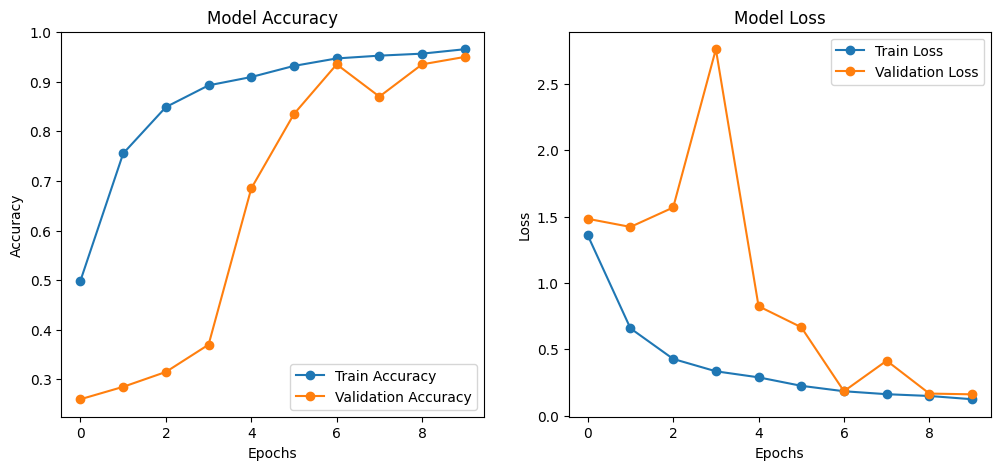

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix


test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")


y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes


print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))


def plot_history(history):
    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Model Accuracy')


    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Model Loss')

    plt.show()


plot_history(history)


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


def plot_confusion_matrix(y_true, y_pred, class_names, normalize=False):
    cm = confusion_matrix(y_true, y_pred)


    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names, linewidths=0.5)

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Random Forest Confusion Matrix" + (" (Normalized)" if normalize else ""))
    plt.show()


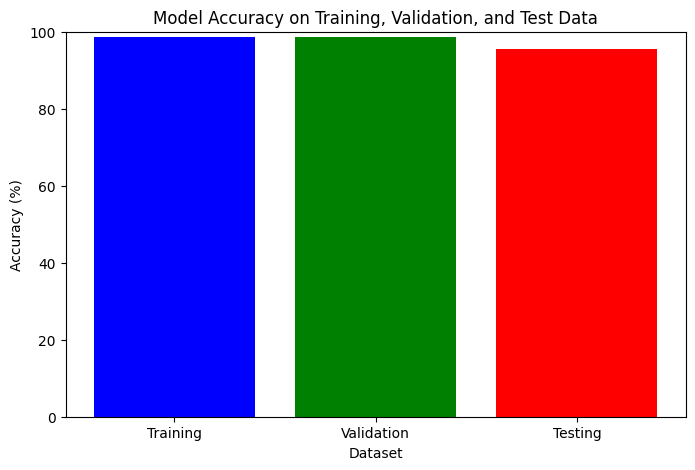

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


train_accuracy = 98.59
val_accuracy = 98.50
test_accuracy = 95.45


labels = ['Training', 'Validation', 'Testing']
accuracies = [train_accuracy, val_accuracy, test_accuracy]


plt.figure(figsize=(8, 5))
plt.bar(labels, accuracies, color=['blue', 'green', 'red'])
plt.xlabel('Dataset')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy on Training, Validation, and Test Data')
plt.ylim([0, 100])
plt.show()


In [ ]:

feature_extractor = Model(inputs=base_model.input, outputs=base_model.get_layer("block5_conv3").output)


features = feature_extractor.predict(test_data)


features_reshaped = features.reshape(features.shape[0], -1)
print("Feature Matrix Shape:", features_reshaped.shape)


35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step
Feature Matrix Shape: (1111, 100352)


Loading data...
Data Loaded:
Training: (5712, 128, 128), Testing: (1111, 128, 128), Validation: (200, 128, 128)
Extracting HOG Features...

Training Random Forest...

Random Forest Results:
              precision    recall  f1-score   support

           0       0.85      0.66      0.75       250
           1       0.74      0.82      0.78       256
           2       0.98      0.99      0.99       355
           3       0.85      0.94      0.89       250

    accuracy                           0.86      1111
   macro avg       0.86      0.85      0.85      1111
weighted avg       0.87      0.86      0.86      1111

Random Forest Accuracy: 0.864986498649865


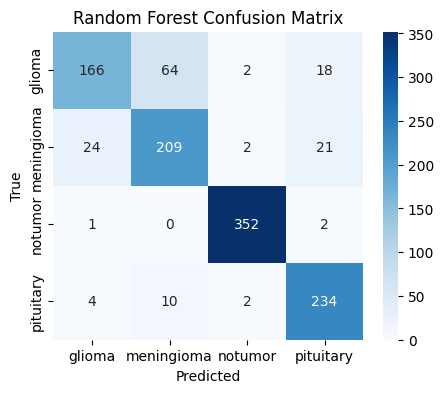


Training SVM...

SVM Results:
              precision    recall  f1-score   support

           0       0.75      0.74      0.74       250
           1       0.63      0.53      0.57       256
           2       0.87      0.95      0.91       355
           3       0.78      0.82      0.80       250

    accuracy                           0.78      1111
   macro avg       0.76      0.76      0.76      1111
weighted avg       0.77      0.78      0.77      1111

SVM Accuracy: 0.7758775877587759


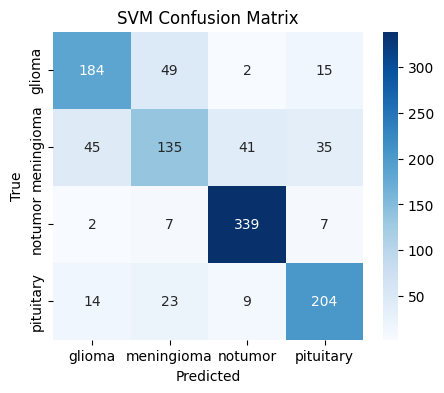


Training Logistic Regression...

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.76      0.72      0.74       250
           1       0.62      0.51      0.56       256
           2       0.85      0.95      0.90       355
           3       0.75      0.80      0.78       250

    accuracy                           0.76      1111
   macro avg       0.74      0.75      0.74      1111
weighted avg       0.75      0.76      0.76      1111

Logistic Regression Accuracy: 0.7632763276327633


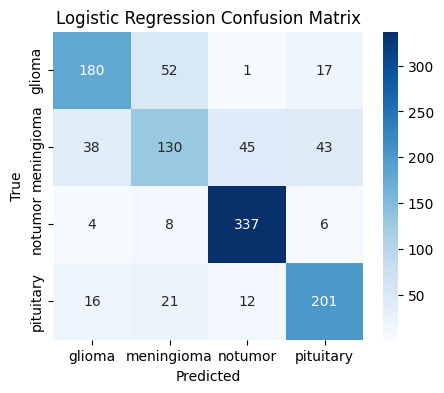


Training Decision Tree...

Decision Tree Results:
              precision    recall  f1-score   support

           0       0.73      0.64      0.68       250
           1       0.63      0.72      0.67       256
           2       0.92      0.90      0.91       355
           3       0.75      0.76      0.76       250

    accuracy                           0.77      1111
   macro avg       0.76      0.76      0.76      1111
weighted avg       0.77      0.77      0.77      1111

Decision Tree Accuracy: 0.7686768676867687


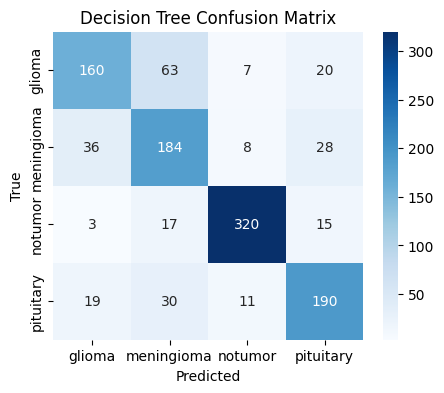


Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:15:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Results:
              precision    recall  f1-score   support

           0       0.85      0.75      0.80       250
           1       0.78      0.81      0.80       256
           2       0.99      1.00      0.99       355
           3       0.89      0.94      0.91       250

    accuracy                           0.89      1111
   macro avg       0.88      0.88      0.88      1111
weighted avg       0.89      0.89      0.89      1111

XGBoost Accuracy: 0.8874887488748875


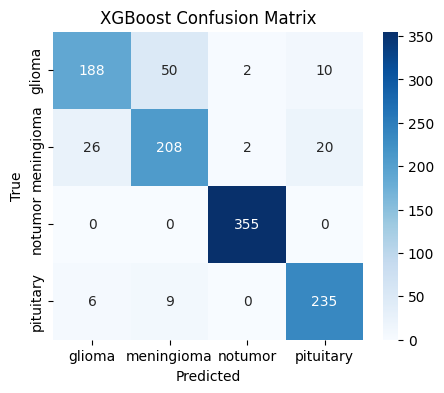


Training KNN...

KNN Results:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       250
           1       0.80      0.62      0.70       256
           2       0.91      0.97      0.94       355
           3       0.84      0.96      0.90       250

    accuracy                           0.85      1111
   macro avg       0.84      0.84      0.84      1111
weighted avg       0.85      0.85      0.85      1111

KNN Accuracy: 0.8523852385238524


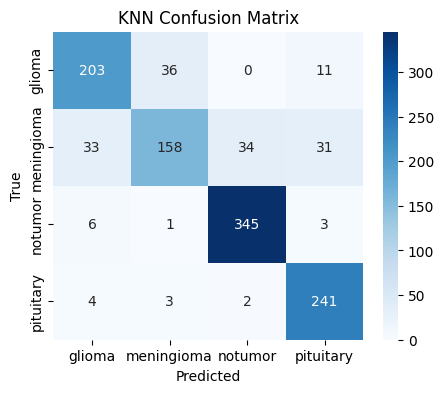

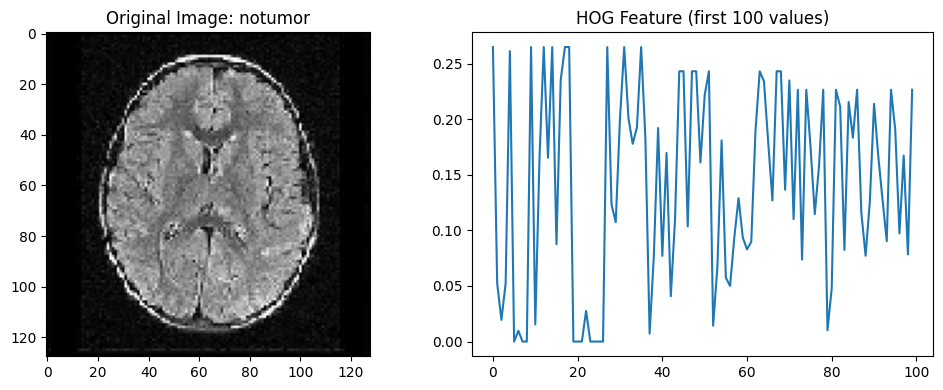

In [ ]:
import os
import cv2
import numpy as np
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from skimage.feature import hog
import matplotlib.pyplot as plt
import seaborn as sns

train_dir = "/content/brain_tumor/brain_tumor/Training"
test_dir = "/content/brain_tumor/brain_tumor/Testing"
val_dir = "/content/brain_tumor/brain_tumor/Validation"

def load_images(directory):
    X = []
    y = []
    class_labels = os.listdir(directory)
    for label in class_labels:
        label_path = os.path.join(directory, label)
        for img_name in os.listdir(label_path):
            img_path = os.path.join(label_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (128, 128))
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                X.append(gray)
                y.append(label)
    return np.array(X), np.array(y)

print("Loading data...")
X_train_raw, y_train = load_images(train_dir)
X_test_raw, y_test = load_images(test_dir)
X_val_raw, y_val = load_images(val_dir)

print("Data Loaded:")
print(f"Training: {X_train_raw.shape}, Testing: {X_test_raw.shape}, Validation: {X_val_raw.shape}")

def extract_hog_features(images):
    features = []
    for img in images:
        hog_feature = hog(img, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), block_norm='L2-Hys')
        features.append(hog_feature)
    return np.array(features)

print("Extracting HOG Features...")
X_train_hog = extract_hog_features(X_train_raw)
X_test_hog = extract_hog_features(X_test_raw)
X_val_hog = extract_hog_features(X_val_raw)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_hog)
X_test_scaled = scaler.transform(X_test_hog)
X_val_scaled = scaler.transform(X_val_hog)

selector = SelectKBest(score_func=f_classif, k=100)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)
X_val_selected = selector.transform(X_val_scaled)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
y_val_enc = le.transform(y_val)


def train_and_evaluate_model(model, model_name):
    print(f"\nTraining {model_name}...")
    model.fit(X_train_selected, y_train_enc)
    y_pred = model.predict(X_test_selected)

    print(f"\n{model_name} Results:")
    print(classification_report(y_test_enc, y_pred))
    print(f"{model_name} Accuracy:", accuracy_score(y_test_enc, y_pred))

    cm = confusion_matrix(y_test_enc, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


models = [
    (RandomForestClassifier(n_estimators=100, random_state=42), "Random Forest"),
    (SVC(kernel='linear', probability=True), "SVM"),
    (LogisticRegression(max_iter=1000), "Logistic Regression"),
    (DecisionTreeClassifier(random_state=42), "Decision Tree"),
    (xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'), "XGBoost"),
    (KNeighborsClassifier(n_neighbors=5), "KNN")
]

for model, name in models:
    train_and_evaluate_model(model, name)


index = 0
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(X_train_raw[index], cmap='gray')
plt.title(f"Original Image: {y_train[index]}")

plt.subplot(1, 2, 2)
plt.plot(X_train_hog[index][:100])
plt.title("HOG Feature (first 100 values)")
plt.tight_layout()
plt.show()



Training XGBoost Model...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:13:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Results:
              precision    recall  f1-score   support

           0       0.85      0.75      0.80       250
           1       0.78      0.81      0.80       256
           2       0.99      1.00      0.99       355
           3       0.89      0.94      0.91       250

    accuracy                           0.89      1111
   macro avg       0.88      0.88      0.88      1111
weighted avg       0.89      0.89      0.89      1111

XGBoost Accuracy: 0.8874887488748875


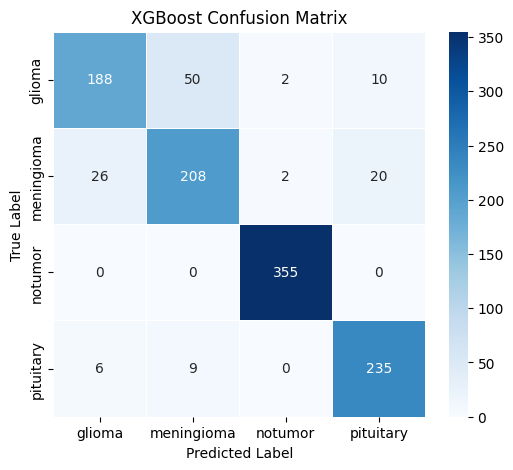

In [ ]:
import os
import cv2
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from skimage.feature import hog
import matplotlib.pyplot as plt
import seaborn as sns


train_dir = "/content/brain_tumor/brain_tumor/Training"
test_dir = "/content/brain_tumor/brain_tumor/Testing"
val_dir = "/content/brain_tumor/brain_tumor/Validation"


def load_images(directory):
    X, y = [], []
    class_labels = os.listdir(directory)
    for label in class_labels:
        label_path = os.path.join(directory, label)
        for img_name in os.listdir(label_path):
            img_path = os.path.join(label_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (128, 128))
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                X.append(gray)
                y.append(label)
    return np.array(X), np.array(y)


X_train_raw, y_train = load_images(train_dir)
X_test_raw, y_test = load_images(test_dir)


def extract_hog_features(images):
    features = []
    for img in images:
        hog_feature = hog(img, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), block_norm='L2-Hys')
        features.append(hog_feature)
    return np.array(features)

X_train_hog = extract_hog_features(X_train_raw)
X_test_hog = extract_hog_features(X_test_raw)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_hog)
X_test_scaled = scaler.transform(X_test_hog)


selector = SelectKBest(score_func=f_classif, k=100)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)


def train_xgboost():
    print("\nTraining XGBoost Model...")
    xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    xgb_model.fit(X_train_selected, y_train_enc)

    y_pred_xgb = xgb_model.predict(X_test_selected)


    print("\nXGBoost Results:")
    print(classification_report(y_test_enc, y_pred_xgb))
    print("XGBoost Accuracy:", accuracy_score(y_test_enc, y_pred_xgb))

    return y_pred_xgb, le.classes_

def plot_xgboost_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names, linewidths=0.5)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("XGBoost Confusion Matrix")
    plt.show()


y_pred_xgb, class_names = train_xgboost()
plot_xgboost_confusion_matrix(y_test_enc, y_pred_xgb, class_names)
